# Segregation

棲み分け (Segregation) がなぜ起こるのか？

Schellingによるモデル……

individual prefercenceに基づいてagentが移動。Moore neighborhood (四角い)とvon Neumann neighborhood　（上下左右にトゲトゲ）の2種類の「隣人」に基づき移動を決定する。

コラム：Conway's Game of Life

https://www.youtube.com/watch?v=Kk2MH9O4pXY

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Button, VBox
from IPython.display import display

def count_same_color_neighbors(grid, x, y):
    """
    (x, y) の近傍8マスについて、自分と同じ色のエージェントが
    いくつあるかと、周囲エージェントの総数を返す。
    
    トーラス境界：端で折り返す。
    """
    color = grid[x, y]
    if color is None:
        return 0, 0
    same_color_count = 0
    agent_count = 0

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            # トーラス境界
            nx = (x + dx) % n
            ny = (y + dy) % n

            neighbor_color = grid[nx, ny]
            if neighbor_color is not None:
                agent_count += 1
                if neighbor_color == color:
                    same_color_count += 1
    return same_color_count, agent_count

def find_empty_neighbors(grid, x, y):
    """
    (x, y) の近傍8マスのうち、空いているマスのリストを返す。
    
    トーラス境界：端で折り返す。
    """
    empty_positions = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx = (x + dx) % n
            ny = (y + dy) % n

            if grid[nx, ny] is None:
                empty_positions.append((nx, ny))
    return empty_positions

def step(grid):
    """
    1ステップ分の更新を行い、新しいgridを返す。
    - 周囲8マスのうち同色が過半数に満たなければ、空きのある近傍マスへランダムに移動。
    - 同色が過半数以上ならその場にとどまる。
    - 今回は「先着順」で移動先を確保している簡易版。
    """
    new_grid = grid.copy()
    moves = []

    for x in range(n):
        for y in range(n):
            if grid[x, y] is None:
                continue
            same_color_count, agent_count = count_same_color_neighbors(grid, x, y)
            neighbor_rate = same_color_count / 8
            need_move = False
            if neighbor_rate < tolerance:
                need_move = True
            if need_move:
                empty_positions = find_empty_neighbors(grid, x, y)
                if len(empty_positions) > 0:
                    new_pos = random.choice(empty_positions)
                    moves.append((x, y, new_pos[0], new_pos[1]))

    # 競合を考慮してランダム順に処理(先着優先)
    random.shuffle(moves)
    for x, y, nx, ny in moves:
        c = grid[x, y]
        # 移動元にまだ自分がいて、移動先が空いていれば
        if new_grid[x, y] == c and new_grid[nx, ny] is None:
            new_grid[x, y] = None
            new_grid[nx, ny] = c

    return new_grid

def plot_grid(grid):
    """
    現在のgrid状態を matplotlib で可視化。散布図 & 枠線(黒いグリッド)付き。
    """
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    
    # 軸の範囲・アスペクト等
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    
    # マス目の黒線 (グリッド境界)
    for i in range(n+1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
        ax.axvline(i - 0.5, color='black', linewidth=1)

    # 実際のエージェントを描画
    for x in range(n):
        for y in range(n):
            c = grid[x, y]
            if c is not None:
                # (y, x) の順で描いているので注意
                ax.scatter(y, x, color=c, s=1000, marker='s')

    plt.title("Grid State (Toroidal Boundaries)")
    plt.show()




# ------------- アニメーション用関数 -------------
from matplotlib import animation
from IPython.display import HTML

def animate_schelling(grid, num_steps=20, interval=500):
    """
    Schellingモデルのグリッドをアニメーション表示する関数。
    
    Parameters
    ----------
    grid : ndarray(shape=(n,n), dtype=object)
        初期状態のグリッド (None, 'red', 'blue' などが格納)
    num_steps : int
        何ステップ実行するか
    interval : int
        アニメーション再生速度(フレーム間隔 ms)
    
    Returns
    -------
    HTML
        Jupyter/Colab上で動画を表示するためのHTMLオブジェクト
    """
    # 各ステップのgrid状態をリストに保存
    states = [grid.copy()]
    current_grid = grid.copy()
    for _ in range(num_steps):
        current_grid = step(current_grid)
        states.append(current_grid.copy())

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.title("Schelling Model Animation")

    # マス目の黒線
    for i in range(n+1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
        ax.axvline(i - 0.5, color='black', linewidth=1)

    # 散布図ハンドル (初期フレーム用)
    # まず初期ステップ(0番目)の可視化用データを抽出
    def get_scatter_data(g):
        x_coords = []
        y_coords = []
        colors_list = []
        for x in range(n):
            for y in range(n):
                if g[x, y] is not None:
                    # 注意: scatterのプロットは (x座標=列, y座標=行) のように扱われるので
                    #       普段の (grid[x][y] で x=row, y=col) との対応に注意
                    x_coords.append(y)
                    y_coords.append(x)
                    colors_list.append(g[x, y])
        return x_coords, y_coords, colors_list

    x0, y0, c0 = get_scatter_data(states[0])
    scat = ax.scatter(x0, y0, c=c0, s=100, marker='s')

    # 各フレームの更新処理
    def update(frame):
        xdata, ydata, coldata = get_scatter_data(states[frame])
        # 座標をまとめて更新
        scat.set_offsets(np.c_[xdata, ydata])
        # 色を更新
        scat.set_color(coldata)
        return (scat,)

    anim = animation.FuncAnimation(
        fig, update, frames=len(states), interval=interval, blit=False
    )
    return HTML(anim.to_jshtml())

# ------------- 実行例 -------------
# Jupyter / Colab 上で以下を実行するとアニメーション表示

In [2]:

# ランダム種(必要なら固定)
# np.random.seed(0)
# random.seed(0)
# パラメータ
n = 30  # グリッドの大きさ n×n
colors = ['red', 'blue',"yellow","black"]
empty_prob = 0.3  # 空マスの割合(初期生成時)
tolerance = 0.33 # 教科書のS


# 初期状態作成
grid = np.full((n, n), None, dtype=object)
for x in range(n):
    for y in range(n):
        if random.random() < empty_prob:
            grid[x, y] = None
        else:
            grid[x, y] = random.choice(colors)

            
#animate_schelling(grid, num_steps=1000, interval=500)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation
import matplotlib as mpl
from IPython.display import HTML
mpl.rcParams["animation.embed_limit"] = 10  # 50MBまで許可

# ---- 質問文にある既存の関数は流用します ----
def count_same_color_neighbors(grid, x, y):
    color = grid[x, y]
    if color is None:
        return 0, 0
    same_color_count = 0
    agent_count = 0
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx = (x + dx) % n
            ny = (y + dy) % n
            neighbor_color = grid[nx, ny]
            if neighbor_color is not None:
                agent_count += 1
                if neighbor_color == color:
                    same_color_count += 1
    return same_color_count, agent_count

def find_empty_neighbors(grid, x, y):
    empty_positions = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx = (x + dx) % n
            ny = (y + dy) % n
            if grid[nx, ny] is None:
                empty_positions.append((nx, ny))
    return empty_positions

def step(grid):
    new_grid = grid.copy()
    moves = []
    for x in range(n):
        for y in range(n):
            if grid[x, y] is None:
                continue
            same_color_count, agent_count_8 = count_same_color_neighbors(grid, x, y)
            neighbor_rate = same_color_count / 8
            need_move = (neighbor_rate < tolerance)
            if need_move:
                empty_positions = find_empty_neighbors(grid, x, y)
                if len(empty_positions) > 0:
                    new_pos = random.choice(empty_positions)
                    moves.append((x, y, new_pos[0], new_pos[1]))

    random.shuffle(moves)
    for x, y, nx, ny in moves:
        c = grid[x, y]
        if new_grid[x, y] == c and new_grid[nx, ny] is None:
            new_grid[x, y] = None
            new_grid[nx, ny] = c
    return new_grid

# グリッド上のエージェント座標や色をscatter用に取得する
def get_scatter_data(g):
    x_coords = []
    y_coords = []
    colors_list = []
    for xx in range(n):
        for yy in range(n):
            if g[xx, yy] is not None:
                x_coords.append(yy)
                y_coords.append(xx)
                colors_list.append(g[xx, yy])
    return x_coords, y_coords, colors_list

# メトリクス計算
def compute_metrics(grid):
    """
    gridを全走査して、
      - neighbor_rate の平均
      - need_move(True) なエージェント数
    を返す
    """
    total_neighbor_rate = 0.0
    agent_count = 0
    need_move_count = 0
    for x in range(n):
        for y in range(n):
            c = grid[x, y]
            if c is not None:
                same_color_count, _ = count_same_color_neighbors(grid, x, y)
                nr = same_color_count / 8
                total_neighbor_rate += nr
                agent_count += 1
                if nr < tolerance:
                    need_move_count += 1
    if agent_count == 0:
        avg_nr = 0
    else:
        avg_nr = total_neighbor_rate / agent_count
    return avg_nr, need_move_count

def animate_schelling(grid, num_steps=20, interval=500):
    # 1. 各ステップの状態を保存
    states = [grid.copy()]
    current_grid = grid.copy()
    for _ in range(num_steps):
        current_grid = step(current_grid)
        states.append(current_grid.copy())
    
    # 2. 各ステップのメトリクスを計算してリストに保存
    metrics = []
    for st in states:
        avg_nr, n_move = compute_metrics(st)
        metrics.append((avg_nr, n_move))
    
    # 3. Figure とサブプロットを3つ用意
    #    左 = グリッド, 中央 = neighbor_rate, 右 = need_move
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)  # Grid
    ax2 = fig.add_subplot(1, 3, 2)  # neighbor_rate
    ax3 = fig.add_subplot(1, 3, 3)  # need_move

    # --- ax1 (グリッド) ---
    ax1.set_xlim(-0.5, n - 0.5)
    ax1.set_ylim(-0.5, n - 0.5)
    ax1.set_aspect('equal')
    ax1.invert_yaxis()
    ax1.set_title("Schelling Model Grid")
    for i in range(n + 1):
        ax1.axhline(i - 0.5, color='black', linewidth=1)
        ax1.axvline(i - 0.5, color='black', linewidth=1)
    x0, y0, c0 = get_scatter_data(states[0])
    scat = ax1.scatter(x0, y0, c=c0, s=100, marker='s')

    # --- ax2 (neighbor_rate) ---
    ax2.set_xlim(0, len(states) - 1)
    # y軸はとりあえず0~1あたりを想定(最大1)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Avg. neighbor_rate")
    ax2.set_title("Average similarity")
    line_nr, = ax2.plot([], [], color='blue')

    # --- ax3 (need_move) ---
    ax3.set_xlim(0, len(states) - 1)
    # need_move数は最大でグリッド全エージェント数
    # ざっくり上限を n*n にしておく (全てがエージェント埋めだった場合)
    ax3.set_ylim(0, n*n)
    ax3.set_xlabel("Time Step")
    ax3.set_ylabel("Need Move (count)")
    ax3.set_title("Num of unhappy agents")
    line_nm, = ax3.plot([], [], color='red')

    # 4. update 関数
    def update(frame):
        # (a) グリッドの更新
        xdata, ydata, coldata = get_scatter_data(states[frame])
        scat.set_offsets(np.c_[xdata, ydata])
        scat.set_color(coldata)

        # (b) neighbor_rate のライン更新
        x_range = np.arange(frame + 1)
        nr_vals = [m[0] for m in metrics[:frame+1]]
        line_nr.set_data(x_range, nr_vals)

        # (c) need_move のライン更新
        nm_vals = [m[1] for m in metrics[:frame+1]]
        line_nm.set_data(x_range, nm_vals)

        # 必要に応じて自動スケーリングさせたい場合は下記を呼ぶ:
        # ax2.relim(); ax2.autoscale_view()
        # ax3.relim(); ax3.autoscale_view()

        return scat, line_nr, line_nm

    anim = animation.FuncAnimation(
        fig, update, frames=len(states), interval=interval, blit=False
    )
    return HTML(anim.to_jshtml())



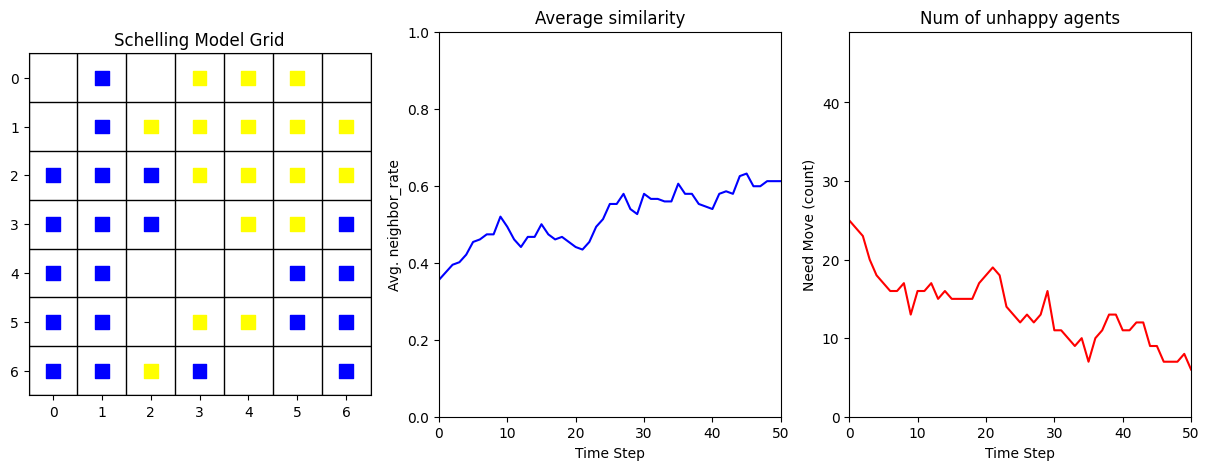

In [8]:
# --------------------------------------
# 試しにパラメータをセットして実行
n = 7

tolerance = 0.5
grid = np.empty((n, n), dtype=object)
colors = ['yellow', 'blue']
empty_rate = 0.2

# 適当に初期化
for i in range(n):
    for j in range(n):
        if random.random() < empty_rate:
            grid[i, j] = None
        else:
            grid[i, j] = random.choice(colors)

HTML_obj = animate_schelling(grid, num_steps=50, interval=5)
HTML_obj
